In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from river import stream, compose, metrics, base, preprocessing, optim, naive_bayes, linear_model, tree, forest
from river.neural_net.mlp import MLP
from river.neural_net import activations

import pandas as pd

In [3]:
random_state = np.random.RandomState(seed=42)

def generate_dists(dist_params, base_len=2000):
    dists = []

    for mu, sigma in dist_params:
        t = base_len + random_state.randint(-50, 50)
        dist = random_state.normal(mu, sigma, t)
        dists.append(dist)
    
    return dists

In [4]:
dist_params = [
    (0.3993, 0.0425),
    (0.7389, 0.0543),
    (0.2850, 0.0559),
    (0.8022, 0.0343),
    (0.4031, 0.0550)
] 

dists = generate_dists(dist_params, base_len=5000)
data_stream = np.concatenate(dists)

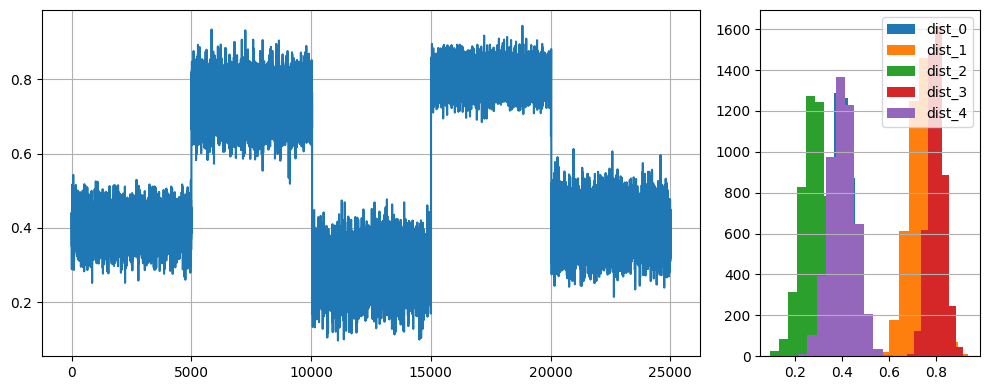

In [5]:
def plot_data(dists, drifts=None):
    _ = plt.figure(figsize=(10,4), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    
    ax1.grid()
    ax1.plot(data_stream, label='Stream')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')

    ax2.grid(axis='y')
    for i, dist in enumerate(dists):
        ax2.hist(dist, label=f'dist_{i}')

    plt.legend()
    plt.show()

plot_data(dists)

In [6]:
def generate_ys(dist_params, dists):
    ys = None

    for i, ((mu, sigma), xs) in enumerate(zip(dist_params, dists)):
        labels = np.where((xs - mu) > sigma / 2, np.ones_like(xs, dtype=int), np.zeros_like(xs, dtype=int))
        ys = labels if ys is None else np.concat([ys, labels])

    return ys

In [7]:
labels = generate_ys(dist_params, dists)

In [8]:
n = 20
for x, y in stream.iter_array(data_stream[:n, np.newaxis], labels[:n]):
    print(x, y)

{0: 0.35204509498300585} 0
{0: 0.41285334284929875} 0
{0: 0.41115925491850586} 0
{0: 0.4422468996042774} 1
{0: 0.3746126793040006} 0
{0: 0.3769802831949287} 0
{0: 0.37501634295544894} 0
{0: 0.36002647939574806} 0
{0: 0.28826666696052194} 0
{0: 0.4396907115018684} 1
{0: 0.4339989159404314} 1
{0: 0.3345352701013259} 0
{0: 0.38110804227251005} 0
{0: 0.3677477094224352} 0
{0: 0.36940788842743516} 0
{0: 0.3083661221167598} 0
{0: 0.37254731416071935} 0
{0: 0.42470311984378584} 1
{0: 0.5080782413191062} 1
{0: 0.41605490342988305} 0


In [9]:
def plot_history(history, model_name):
    xs = np.arange(len(history))
    plt.plot(xs, history, label="Accuracy")

    plt.title(model_name)
    plt.legend()
    plt.show()

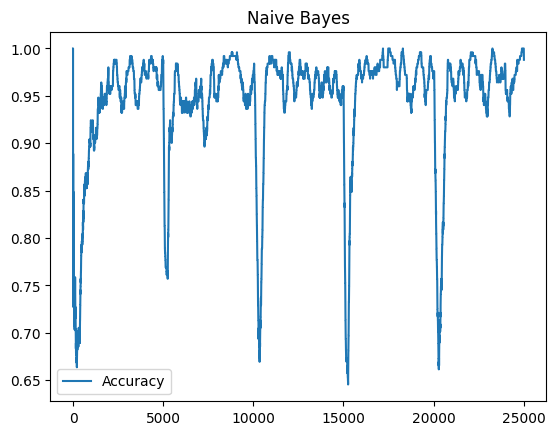

In [10]:
model = compose.Select(0)
model |= preprocessing.AdaptiveStandardScaler(fading_factor=0.01)
model |= naive_bayes.GaussianNB()

metric = metrics.Accuracy()

history = []
dataset = stream.iter_array(data_stream[:, np.newaxis], labels[:])

stack = []
for x, y in dataset:
    model.learn_one(x, y)
    y_pred = model.predict_one(x)

    metric.update(y, y_pred)
    if len(stack) > 250:
        metric.revert(*stack[0])
        stack = stack[1:]
    stack.append((y, y_pred))    
    
    history.append(metric.get())

plot_history(history, "Naive Bayes")

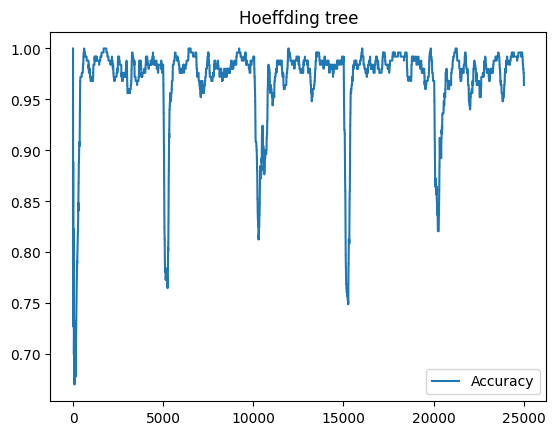

In [11]:
model = compose.Select(0)
model |= preprocessing.AdaptiveStandardScaler(fading_factor=0.01)
model |= tree.HoeffdingAdaptiveTreeClassifier()

metric = metrics.Accuracy()

history = []
dataset = stream.iter_array(data_stream[:, np.newaxis], labels[:])

stack = []
for x, y in dataset:
    model.learn_one(x, y)
    y_pred = model.predict_one(x)

    metric.update(y, y_pred)
    if len(stack) > 250:
        metric.revert(*stack[0])
        stack = stack[1:]
    stack.append((y, y_pred))    
    
    history.append(metric.get())

plot_history(history, "Hoeffding tree")

In [109]:
def elm_init(dims: tuple[int, ...], seed: int | None = None):
    rng = np.random.RandomState(seed)

    w = {}  # weights
    b = {}  # biases

    for i in range(len(dims) - 1):
        w[i + 1] = rng.randn(dims[i], dims[i + 1]) / np.sqrt(dims[i + 1])
        b[i + 1] = np.zeros(dims[i + 1], dtype=w[i + 1].dtype)

    return w, b

class ELM(base.Regressor, MLP):
    def __init__(
        self,
        hidden_dims,
        activations,
        X, y,
        loss: optim.losses.Loss | None = None,
        optimizer: optim.base.Optimizer | None = None,
        seed: int | None = None,
    ):
        super().__init__(
            hidden_dims=hidden_dims,
            activations=activations,
            loss=loss or optim.losses.Squared(),
            optimizer=optimizer or optim.SGD(0.01),
            seed=seed,
        )

        self.X = X
        self.y = y

        if isinstance(y, pd.Series):
            y = y.to_frame()

        self.w, self.b = elm_init(
            dims=(X.shape[1], *self.hidden_dims, y.shape[1]), seed=self.seed
        )

        self.features = X.columns.to_numpy()
        self.features.sort()
        self.targets = y.columns.to_numpy()

        H = self._forward(X)[1][2]
        H_pinv = np.linalg.pinv(H)
        self.w[2] = H_pinv.dot(y.to_numpy())

    @classmethod
    def _default_params(self):
        from . import activations

        return {
            "hidden_dims": (20,),
            "activations": (activations.ReLU, activations.ReLU, activations.Identity),
        }

    def predict_many(self, X):
        if not hasattr(self, "w"):
            return pd.DataFrame({0: 0}, index=X.index)
        return self(X)

    def predict_one(self, x):
        y_pred = self.predict_many(X=pd.DataFrame([x]))

        # Multi-output
        if len(y_pred.columns) > 1:
            return y_pred.iloc[0].to_dict()

        # Single output
        return y_pred.iloc[0, 0]
    
    def learn_many(self, X, y):
        pass

    def learn_one(self, x, y):
        pass

class IELM(base.Classifier, MLP):
    def __init__(
        self,
        hidden_dims,
        activations,
        loss: optim.losses.Loss | None = None,
        optimizer: optim.base.Optimizer | None = None,
        k = 10,
        epsilon = 0.05,
        block_size = 200,
        seed: int | None = None,
    ):
        super().__init__(
            hidden_dims=hidden_dims,
            activations=activations,
            loss=loss or optim.losses.Squared(),
            optimizer=optimizer or optim.SGD(0.01),
            
            seed=seed,
        )

        self.k = k
        self.epsilon = epsilon
        self.block_size = block_size
        self.observations = 0
        self.sliding_window = None
        self.last_val_acc = 0.0

        self.classifiers = []

    @classmethod
    def _default_params(self):
        from . import activations

        return {
            "hidden_dims": (20,),
            "activations": (activations.ReLU, activations.ReLU, activations.Identity),
        }

    def predict_many(self, X):
        if len(self.classifiers) == 0:
            return pd.DataFrame({0: 0}, index=X.index)

        votes = None
        total_weight = 0.0
        for classifier in self.classifiers:
            prediction = classifier.predict_many(X).to_numpy() * classifier.weight
            votes = prediction if votes is None else votes + prediction
            total_weight += classifier.weight

        votes /= total_weight

        majority_vote = np.argmax(votes, axis=1)
        return pd.DataFrame(majority_vote)

    def learn_many(self, X, y):
        """Train the network.

        Parameters
        ----------
        X
            A DataFrame of shape (batch_size, n_features).
        y
            A DataFrame of shape (batch_size, n_targets).

        """
        
        # Update sliding window and current block size
        if self.sliding_window is None:
            self.sliding_window = (X, y)
        else:
            X_old, y_old = self.sliding_window
            X_new = pd.concat([X, X_old])[:self.block_size]
            y_new = pd.concat([y, y_old])[:self.block_size]
            self.sliding_window = (X_new, y_new)
        
        self.observations += len(X)

        # Wait until n samples are available to create a new classifier
        if len(self.classifiers) < self.k and self.observations >= self.block_size:
            classifier = ELM(self.hidden_dims, self.activations, *self.sliding_window, self.loss, self.optimizer)
            classifier.weight = 1
            self.classifiers.append(classifier)
            self.observations = 0

        # If there are not yet enough classifiers wait
        if len(self.classifiers) != self.k or self.observations < self.block_size:
            return
        
        # Validate the model on the current sliding window
        metric = metrics.Accuracy()

        preds = {}
        accs = {}
        for classifier in self.classifiers:
            acc = metrics.Accuracy()
            preds[classifier] = classifier(self.sliding_window[0])
            for i in range(len(self.sliding_window[0])):
                acc.update(
                    np.argmax(self.sliding_window[1].iloc[i].to_numpy()),
                    np.argmax(preds[classifier].iloc[i].to_numpy())
                )
            accs[classifier] = acc
        
        y_pred = self.predict_many(self.sliding_window[0])

        for i in range(len(self.sliding_window[0])):
            metric.update(
                np.argmax(self.sliding_window[1].iloc[i].to_numpy()), 
                y_pred.iloc[i][0]
            )

        if metric.get() - self.last_val_acc <= self.epsilon:
            # Update weights for each classifier based on their own accuracy
            for classifier, acc in accs.items():
                print(acc.get())
                classifier.weight = 1 / (1 - acc.get() + 1e-6)
            self.last_val_acc = metric.get()
        else:
            self.classifiers = list(map(lambda pair: pair[0], sorted(accs.items(), key=lambda item: item[1])[:self.k//2]))
            self.last_val_acc = 0.0

    def learn_one(self, x, y):
        # Multi-output
        if isinstance(y, dict):
            self.learn_many(X=pd.DataFrame([x]), y=pd.DataFrame([y]))
            return

        # Single output
        self.learn_many(X=pd.DataFrame([x]), y=pd.Series([y]))

    def predict_one(self, x):
        y_pred = self.predict_many(X=pd.DataFrame([x]))

        # Multi-output
        if len(y_pred.columns) > 1:
            return y_pred.iloc[0].to_dict()

        # Single output
        return y_pred.iloc[0, 0]

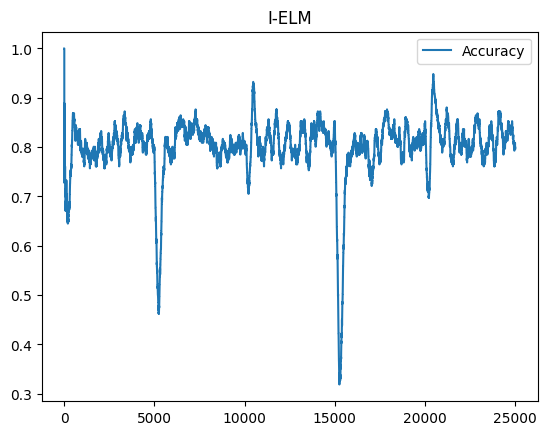

In [110]:
model = compose.Select(0)
model |= preprocessing.AdaptiveStandardScaler(fading_factor=0.01)
model |= IELM(hidden_dims=(200,), activations=(activations.Identity, activations.Sigmoid, activations.Identity))

metric = metrics.Accuracy()

history = []
onehot_labels = np.zeros((labels.size, labels.max() + 1))
onehot_labels[np.arange(labels.size), labels] = 1
dataset = stream.iter_array(data_stream[:, np.newaxis], onehot_labels)

stack = []
for x, one_hot in dataset:
    y = sorted(one_hot.items(), key=lambda item: item[1])[-1][0]

    model.learn_one(x, one_hot)
    y_pred = model.predict_one(x)

    metric.update(y, y_pred)
    if len(stack) > 250:
        metric.revert(*stack[0])
        stack = stack[1:]
    stack.append((y, y_pred))    
    
    history.append(metric.get())

plot_history(history, "I-ELM")

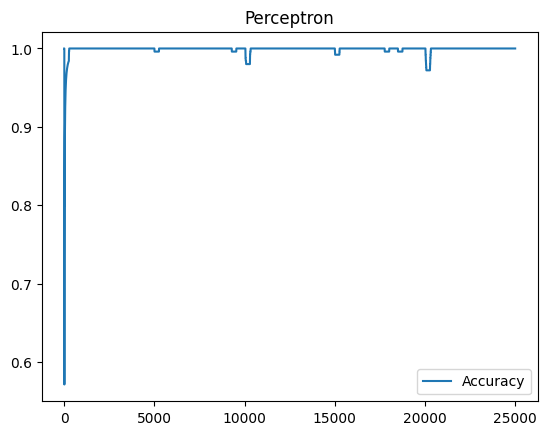

In [ ]:
model = compose.Select(0)
model |= preprocessing.AdaptiveStandardScaler(fading_factor=0.01)
model |= linear_model.perceptron.Perceptron()

metric = metrics.Accuracy()

history = []
dataset = stream.iter_array(data_stream[:, np.newaxis], labels[:])

stack = []
for x, y in dataset:
    model.learn_one(x, y)
    y_pred = model.predict_one(x)

    metric.update(y, y_pred)
    if len(stack) > 250:
        metric.revert(*stack[0])
        stack = stack[1:]
    stack.append((y, y_pred))    
    
    history.append(metric.get())

plot_history(history, "Perceptron")

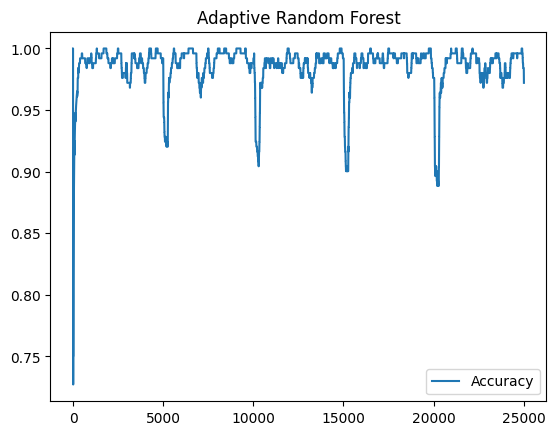

In [ ]:
model = compose.Select(0)
model |= preprocessing.AdaptiveStandardScaler(fading_factor=0.01)
model |= forest.ARFClassifier

metric = metrics.Accuracy()

history = []
dataset = stream.iter_array(data_stream[:, np.newaxis], labels[:])

stack = []
for x, y in dataset:
    model.learn_one(x, y)
    y_pred = model.predict_one(x)

    metric.update(y, y_pred)
    if len(stack) > 250:
        metric.revert(*stack[0])
        stack = stack[1:]
    stack.append((y, y_pred))    
    
    history.append(metric.get())

plot_history(history, "Adaptive Random Forest")